# Seismic inversion of real data

This notebook aims at presenting a simple example of colored seismic inversion. 

We will use both the [Kerry3D data](https://wiki.seg.org/wiki/Kerry-3D) and the [Volve data](https://www.equinor.com/no/how-and-why/digitalisation-in-our-dna/volve-field-data-village-download.html) as input data to our inversion and we will leverage the open-source [segyio](https://github.com/equinor/segyio) and [pylops](https://github.com/equinor/pylops) libraries to accomplish our task as follows:

- Data is read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry)
- Colored inversion is applied by means of pylops.avo.poststack.PoststackInversion 
- Inverted data is saved back to SEG-Y file using segyio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

## Kerry3D

We do not provide you with the data here, but the data can be be easily downloaded running the follow commands

In [2]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy
#!mv Kerry3D.segy ../../data/pylops   

First of all we read our seismic data and display it

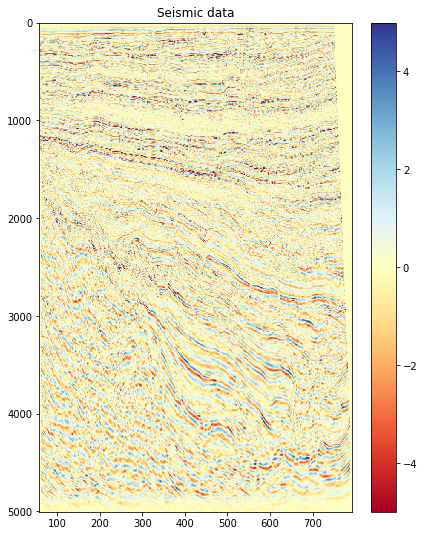

In [3]:
segyfile = '../../data/pylops/Kerry3D.segy'

f = segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                xline=segyio.tracefield.TraceField.CDP)

il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape

plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight');

Let's now try to get a quick estimate of the wavelet in our data using a simple *statistical wavelet* estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

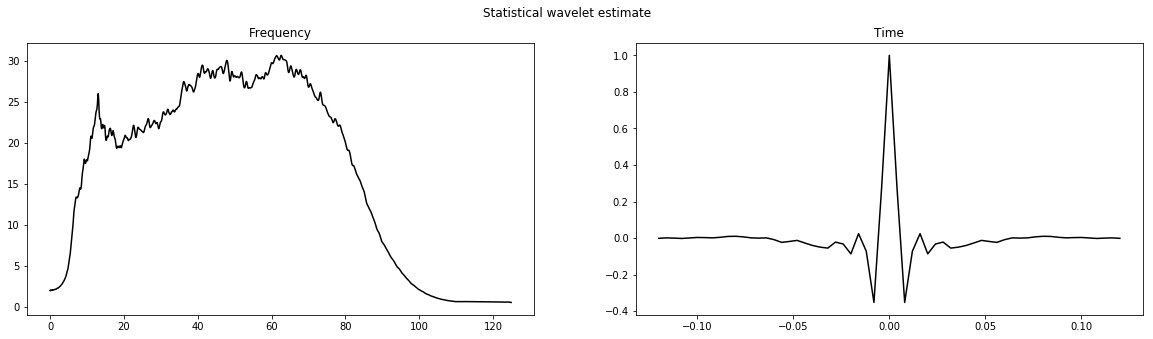

In [4]:
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., :500], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

Let's perform now the inversion

In [5]:
# swap time axis to first dimension
d_small = d[..., :500]
d_small = np.swapaxes(d_small, -1, 0)

m_colored, r_colored = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, epsI=1e-4,
                                            simultaneous=False)
m_colored_reg, r_colored_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_colored, epsI=1e-4, epsR=1e0, 
                                            **dict(iter_lim=10, show=2))
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_colored = np.swapaxes(m_colored, 0, -1)
m_colored_reg = np.swapaxes(m_colored_reg, 0, -1)
r_colored = np.swapaxes(r_colored, 0, -1)
r_colored_reg = np.swapaxes(r_colored_reg, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2.10945e+08 rows  and 1.05472e+08 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.184e+04  2.184e+04    1.0e+00  1.9e-04
     1  0.00000e+00   1.453e+04  1.453e+04    6.7e-01  6.2e-01   5.6e+00  1.0e+00
     2  0.00000e+00   1.065e+04  1.065e+04    4.9e-01  3.4e-01   8.2e+00  2.3e+00
     3  0.00000e+00   8.750e+03  8.750e+03    4.0e-01  2.3e-01   1.0e+01  3.8e+00
     4  0.00000e+00   7.556e+03  7.556e+03    3.5e-01  1.8e-01   1.1e+01  5.4e+00
     5  0.00000e+00   6.756e+03  6.756e+03    3.1e-01  1.4e-01   1.3e+01  7.2e+00
     6  0.00000e+00   6.231e+03  6.231e+03    2.9e-01  1.1e-01   1.4e+01  9.1e+00
     7  0.00000e+00   5.851e+03  5.851e+03    2.7e-01  8.9e-02   1.5e+01  1.1e+01
     8  0.00000e+00   

Let's compare our results

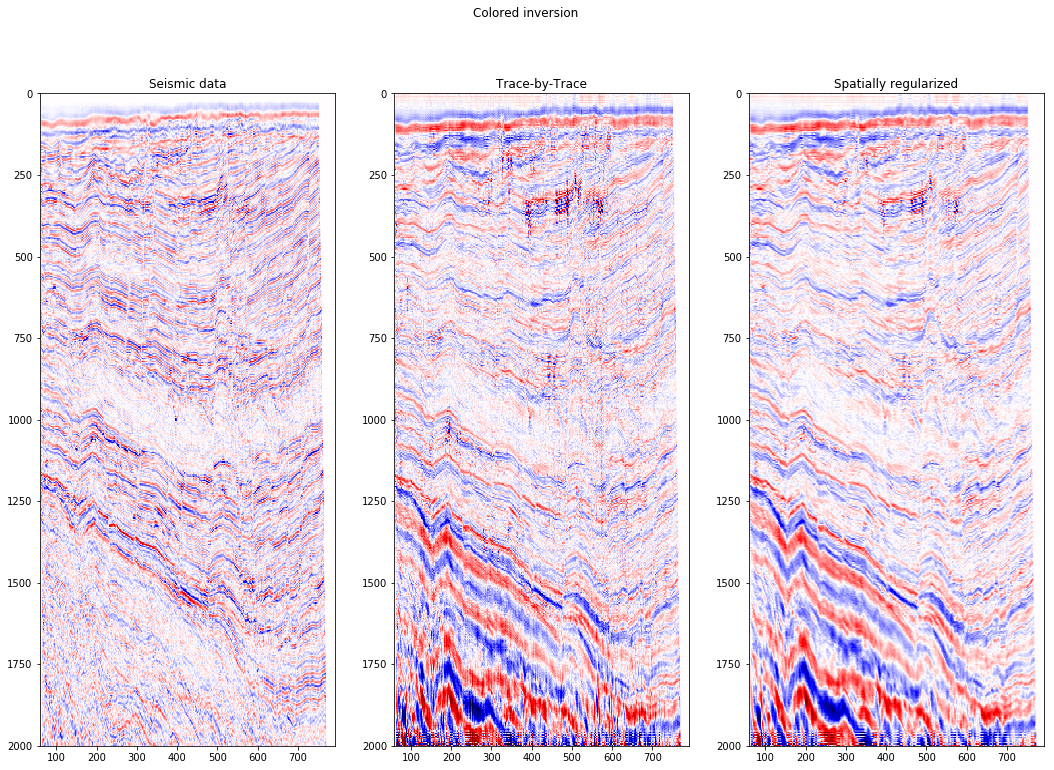

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Colored inversion')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_colored[nil//2].T, cmap='seismic', vmin=-0.2*m_colored.max(), vmax=0.2*m_colored.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_colored_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_colored.max(), vmax=0.2*m_colored.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

And a little close up

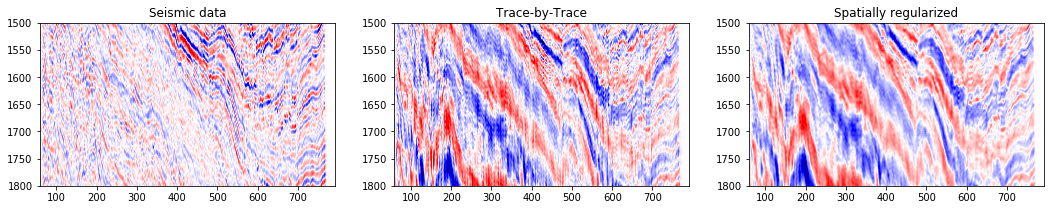

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(d_small[nil//2].T, cmap='seismic', interpolation='sinc', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[0].set_ylim(1800, 1500)
axs[1].imshow(m_colored[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_colored.max(), vmax=0.2*m_colored.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[1].set_ylim(1800, 1500)
axs[2].imshow(m_colored_reg[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_colored.max(), vmax=0.2*m_colored.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight')
axs[2].set_ylim(1800, 1500);

And a time slice

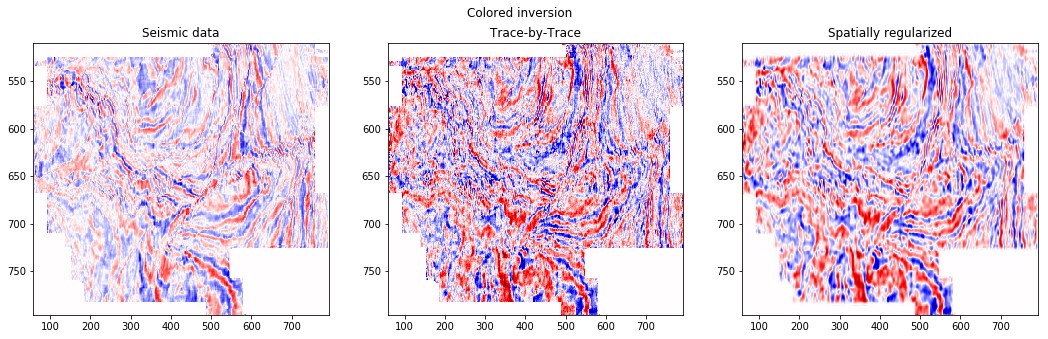

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Colored inversion')
axs[0].imshow(d_small[...,200], cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_colored[...,200], cmap='seismic', vmin=-0.1*m_colored.max(), vmax=0.1*m_colored.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_colored_reg[...,200], cmap='seismic', vmin=-0.1*m_colored.max(), vmax=0.1*m_colored.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

Finally we display the residuals

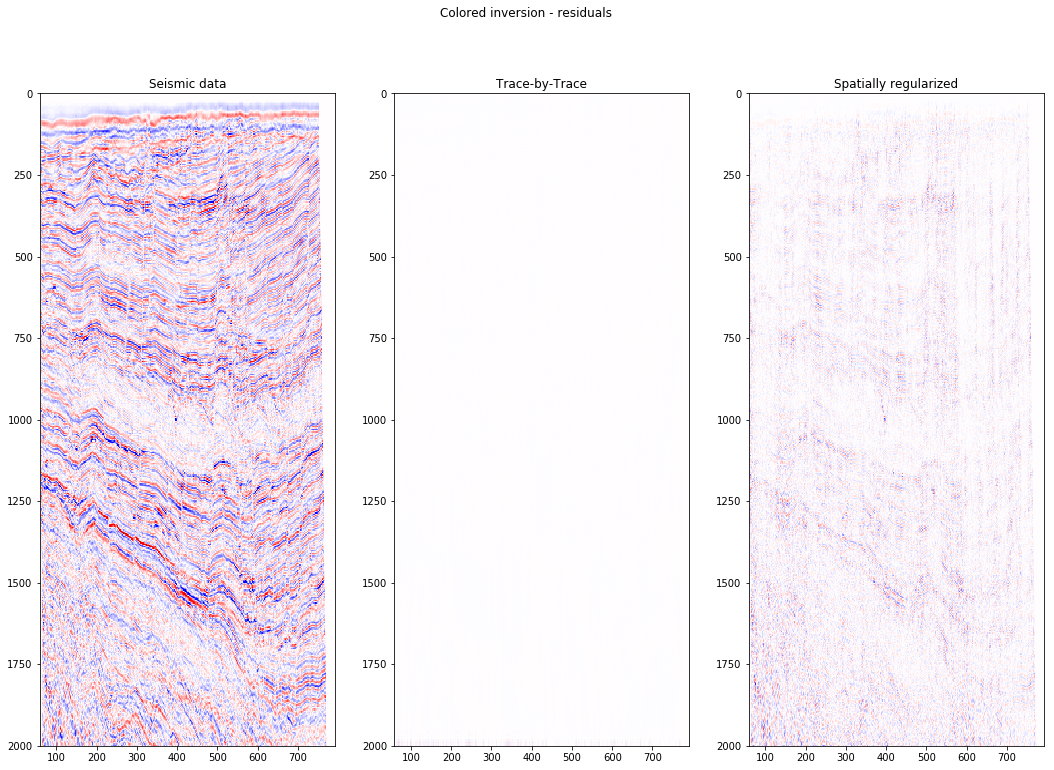

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Colored inversion - residuals')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_colored[nil//2].T, cmap='seismic', vmin=-10, vmax=10, 
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_colored_reg[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

Finally we save the cube (with limited time axis) back to segy file and we change the location of ilines and crosslines to the more common locations segyio.TraceField.INLINE_3D (189) and segyio.TraceField.CROSSLINE_3D (193)

In [10]:
segyfile_inverted = '../../data/pylops/Kerry3D_inverted.segy'

with segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                 xline=segyio.tracefield.TraceField.CDP) as src:
        spec = segyio.spec()
        spec.sorting = int(src.sorting)
        spec.format = int(src.format)
        spec.samples = t[:500]
        spec.ilines = src.ilines
        spec.xlines = src.xlines

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: 500}
            
            # Copy all trace headers to destination file
            dst.header.iline = src.header.iline
            
            # Modify headers to have IL and XL at more standard bytes
            tr = 0
            for il in spec.ilines:
                for xl in spec.xlines:
                    dst.header[tr] = {
                        segyio.tracefield.TraceField.INLINE_3D : il,
                        segyio.tracefield.TraceField.CROSSLINE_3D : xl,
                        segyio.TraceField.TRACE_SAMPLE_COUNT: 500} 
                    tr +=1

            # Copy data
            for iil, iline in enumerate(dst.ilines):
                dst.iline[iline] = m_colored[iil].astype('float32')

Let's just read the file back

In [11]:
m_saved = segyio.cube(segyfile_inverted)

np.allclose(m_colored, m_saved)

True

In [12]:
!rm ../../data/pylops/Kerry3D_inverted.segy

## Volve data

Again, we cannot provide the data given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the `Azure CLI`

In [13]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy ../../data/pylops   

where you will need to substitute `$YOURTOKEN` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of `$YOURTOKEN`.

Let's now read the Volve data. 

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy array as it was the case for the Kerry3D data.

In [14]:
segyfile = '../../data/pylops/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'

f = segyio.open(segyfile, ignore_geometry=True)

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work

In [15]:
t = f.samples
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

# define a regular IL and XL axis
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# regular axis
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))
print('# missing traces: {}'.format(np.sum(~traces_available)))

# reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# missing traces: 26


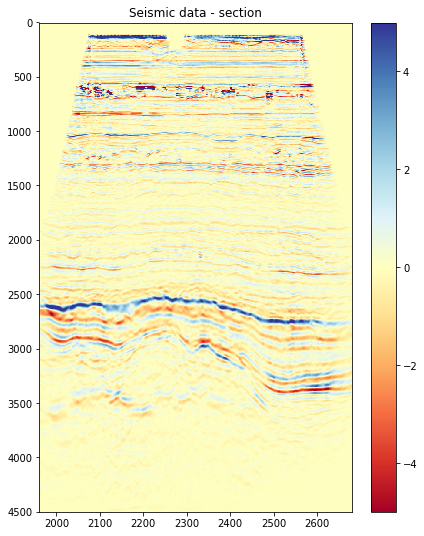

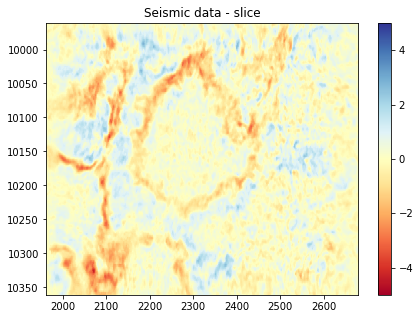

In [16]:
plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(7, 5))
plt.imshow(d[..., nt//2], cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title('Seismic data - slice')
plt.colorbar()
plt.axis('tight');

Once again, let's estimate the wavelet and apply colored inversion. This time we will target the deeper area

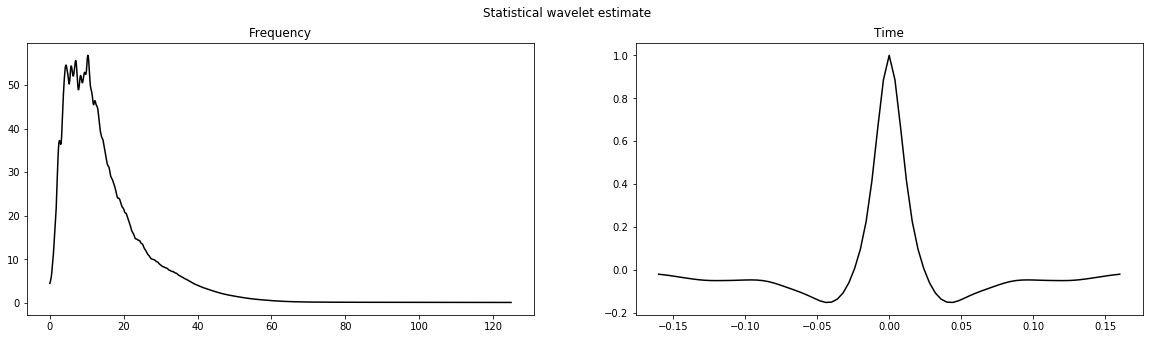

In [17]:
nt_wav = 41 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., 500:], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

In [18]:
# swap time axis to first dimension
itmin, itmax = 500, 950
d_small = d[..., itmin:itmax]
d_small = np.swapaxes(d_small, -1, 0)

m_colored, r_colored = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, 
                                            epsI=1e-3, simultaneous=False)
m_colored_reg, r_colored_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_colored, epsI=1e-4, epsR=5e1, 
                                            **dict(iter_lim=20, show=2))
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_colored = np.swapaxes(m_colored, 0, -1)
m_colored_reg = np.swapaxes(m_colored_reg, 0, -1)
r_colored = np.swapaxes(r_colored, 0, -1)
r_colored_reg = np.swapaxes(r_colored_reg, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2.59848e+08 rows  and 1.29924e+08 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.787e+05  1.787e+05    1.0e+00  1.0e-03
     1 -1.83260e-05   1.170e+05  1.170e+05    6.5e-01  6.7e-01   2.4e+02  1.0e+00
     2 -3.49472e-05   9.192e+04  9.192e+04    5.1e-01  3.2e-01   3.9e+02  2.3e+00
     3 -4.84581e-05   7.868e+04  7.868e+04    4.4e-01  2.2e-01   4.8e+02  3.8e+00
     4 -6.41778e-05   6.912e+04  6.912e+04    3.9e-01  1.8e-01   5.6e+02  5.5e+00
     5 -6.97017e-05   6.202e+04  6.202e+04    3.5e-01  1.4e-01   6.3e+02  7.5e+00
     6  7.65207e-05   5.676e+04  5.676e+04    3.2e-01  1.2e-01   6.9e+02  9.6e+00
     7  5.07641e-04   5.238e+04  5.238e+04    2.9e-01  1.1e-01   7.4e+02  1.2e+01
     8  1.34243e-03   

We can now display the inverted model and residuals

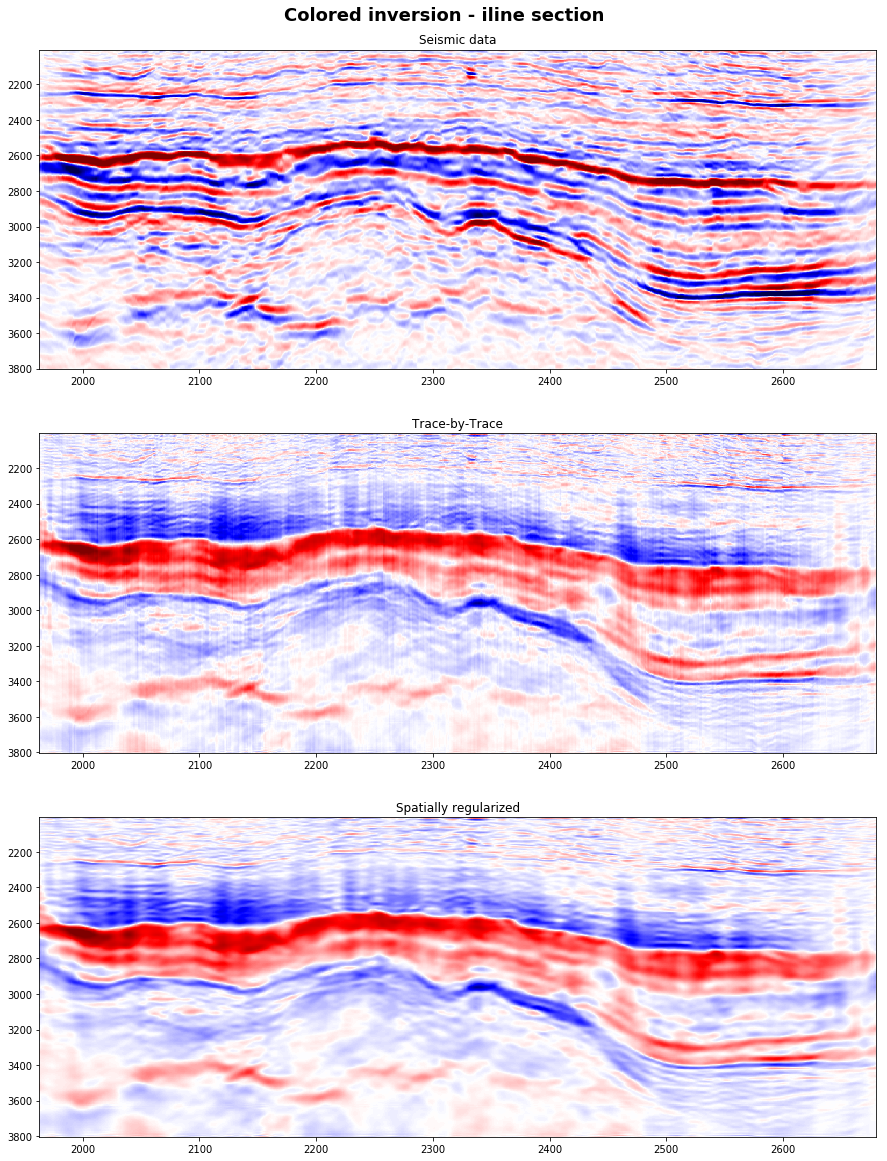

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Colored inversion - iline section', y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_colored[nil//2].T, cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_colored_reg[nil//2].T, cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

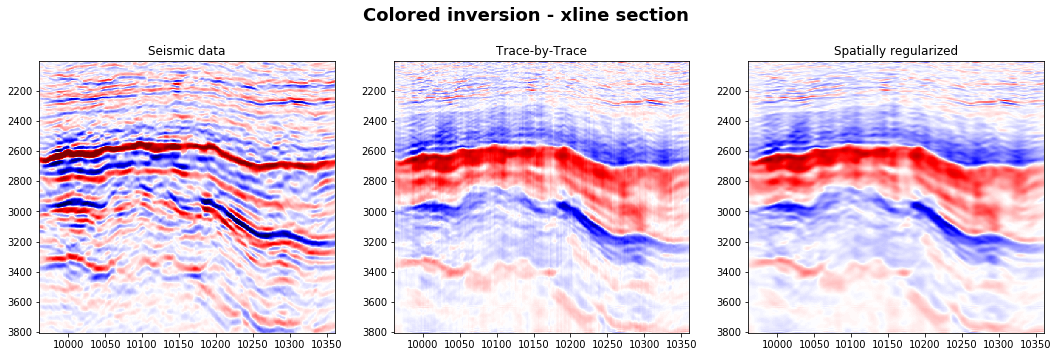

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Colored inversion - xline section', y=1.03, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[:, nxl//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_colored[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_colored_reg[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

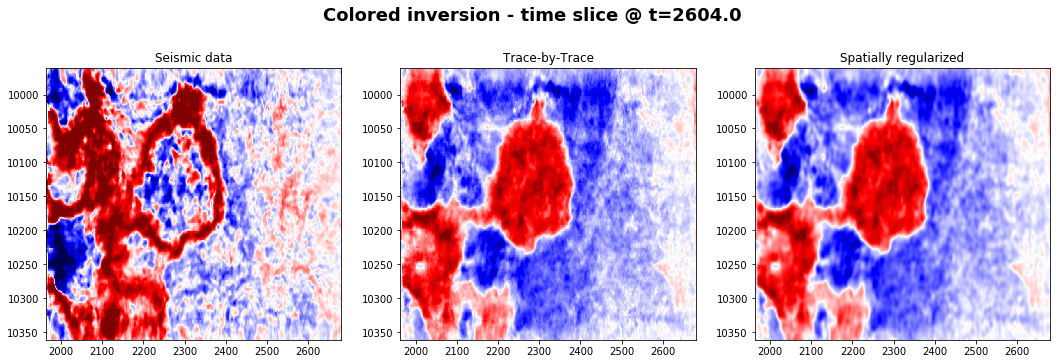

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Colored inversion - time slice @ t={}'.format(t[itmin+150]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[...,150], cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_colored[...,150], cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_colored_reg[...,150], cmap='seismic', vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

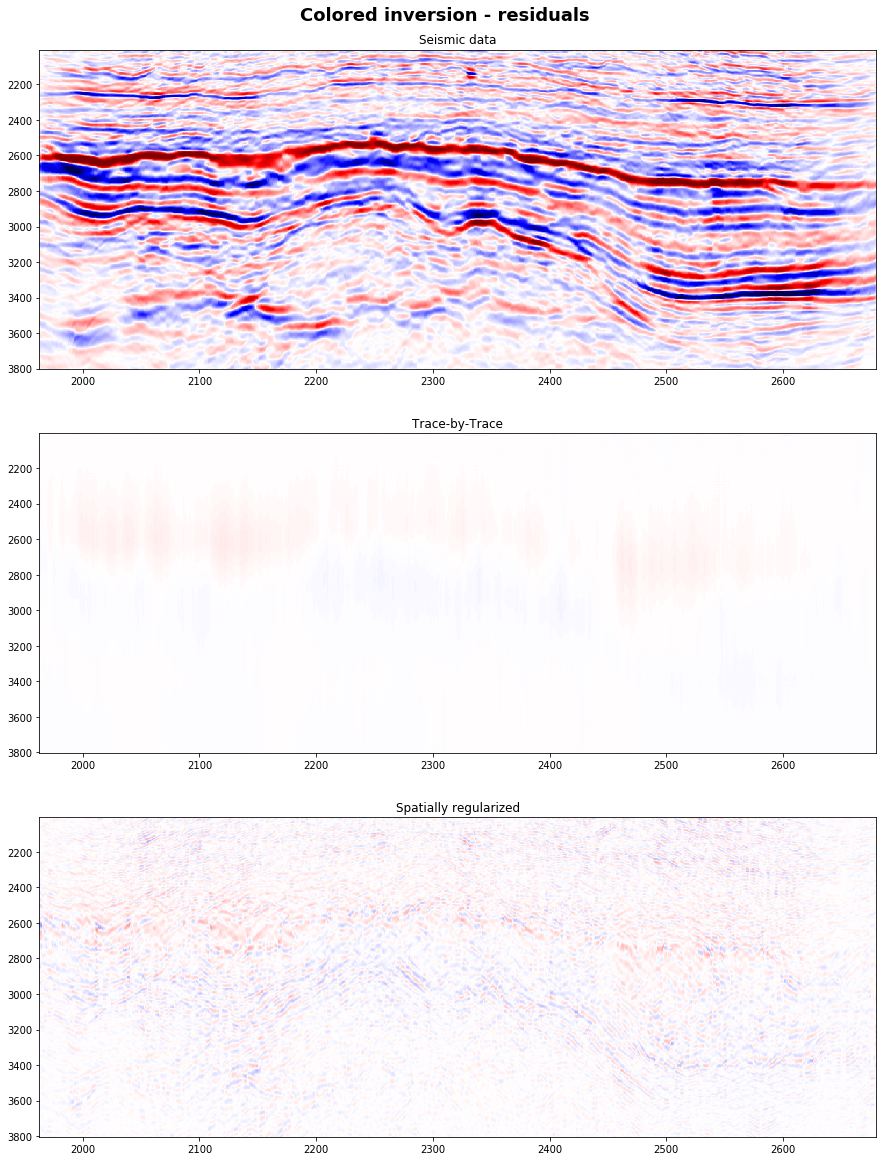

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Colored inversion - residuals', y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_colored[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_colored_reg[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

Finally we write the cube back to a segy

In [23]:
# Bring traces back to their original order
traces_to_save =  m_colored_reg[ilgrid.ravel()[traces_available.ravel()],
                                xlgrid.ravel()[traces_available.ravel()]]

In [24]:
segyfile_inverted = '../../data/pylops/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy'

with segyio.open(segyfile, ignore_geometry=True) as src:
        spec = segyio.spec()
        spec.format = int(src.format)
        spec.samples = t[itmin:itmax]
        spec.tracecount = src.tracecount

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # Copy all trace headers to destination file
            dst.header = src.header 

            # Copy data and modify trace header
            for itrace in range(dst.tracecount):
                dst.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
                dst.trace[itrace] = traces_to_save[itrace].astype('float32')

Again, let's read the file back and check that what we saved is correct

In [25]:
f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
traces1 = segyio.collect(f1.trace)[:]

np.allclose(traces1, traces_to_save)

True

In [26]:
!rm ../../data/pylops/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy